In [1]:
import matplotlib.pyplot as plt

import torch

from torchvision.datasets import MNIST
from torchvision import transforms

from torch.utils.data import DataLoader

from glow import GLOW
import normflows as nf

import torchvision as tv
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_data = MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True, drop_last=True)

flow = GLOW(1, 32, (1, 28, 28), 10, 256)
flow.model.load('models/glow/glow_mnist_1_32_256_100000.pt')

/home/mando/glime/.venv/lib/python3.10/site-packages/torch/_tensor.py:791: UserWarning: torch.lu is deprecated in favor of torch.linalg.lu_factor / torch.linalg.lu_factor_ex and will be removed in a future PyTorch release.
LU, pivots = torch.lu(A, compute_pivots)
should be replaced with
LU, pivots = torch.linalg.lu_factor(A, compute_pivots)
and
LU, pivots, info = torch.lu(A, compute_pivots, get_infos=True)
should be replaced with
LU, pivots, info = torch.linalg.lu_factor_ex(A, compute_pivots) (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1984.)
  LU, pivots, infos = torch._lu_with_info(
/home/mando/glime/.venv/lib/python3.10/site-packages/normflows/core.py:632: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURI

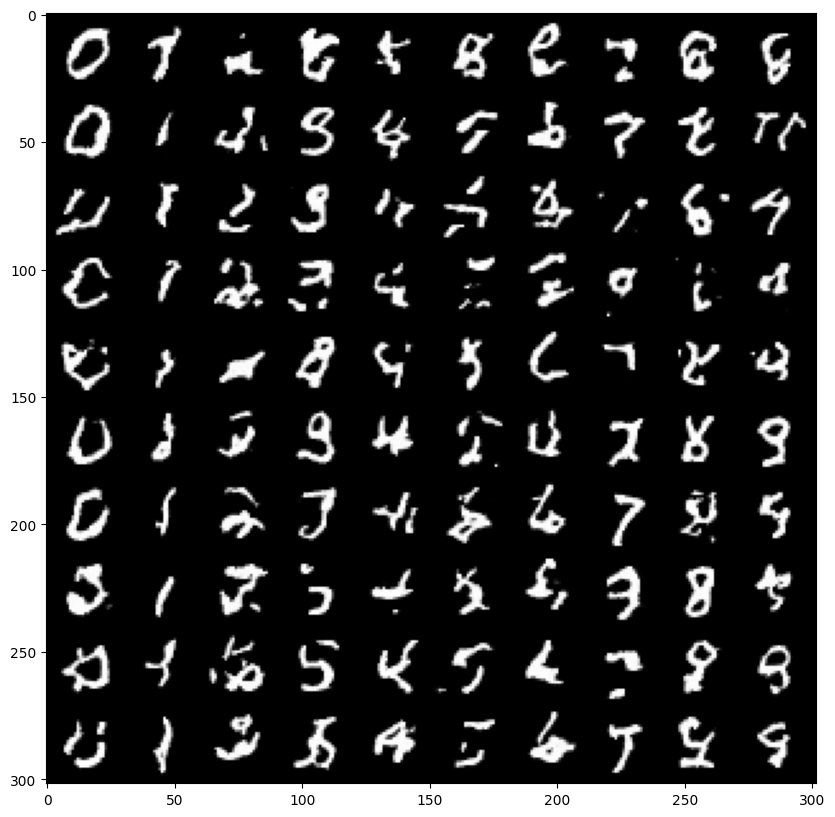

In [3]:
num_sample = 10

with torch.no_grad():
    y = torch.arange(10).repeat(num_sample).to('cuda:1')
    x, _ = flow.model.sample(y=y)
    x_ = torch.clamp(x, 0, 1)
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(tv.utils.make_grid(x_, nrow=10).cpu().numpy(), (1, 2, 0)))
    plt.show()

In [4]:
from PIL import Image
import torchvision.models as models

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

model = models.resnet18(num_classes=10).to(device)
model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False).to(device)

model.load_state_dict(torch.load('models/resnet_mnist.pt'))
model.eval()

def counterfactual(flow, sample, target, confidence, lr=5e-2, max_iter=1000):
    # based on 'Diffeomorphic Explanations with Normalizing Flows', Dombrowski et. al
    latent = flow.to_latent(sample)

    latent[0] = latent[0].detach()
    latent[0].requires_grad = True

    model.requires_grad_(False)

    flow.model.eval()
    flow.model.requires_grad_(False)
    optimizer = torch.optim.Adam([latent[0]], lr=lr)
    for i in range(max_iter):
        optimizer.zero_grad()
        x = flow.to_image(latent)[0]
        output = model(x)
        probs = torch.nn.functional.softmax(output[0], dim=0)
        loss = -probs[target]
        print(f'Iteration {i}, loss: {loss.item()}', end='\r')
        loss.backward(retain_graph=True)
        optimizer.step()
        if probs[target] > confidence:
            break
    return flow.to_image(latent)

/tmp/ipykernel_160409/387703252.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('models/resnet_mnist.pt'))


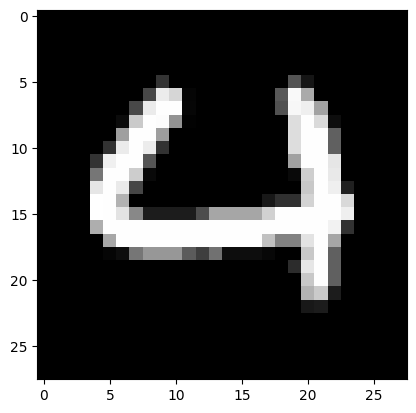

In [5]:
plt.imshow(train_data[60][0].squeeze(), cmap='gray')

/home/mando/glime/lime/glow.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)


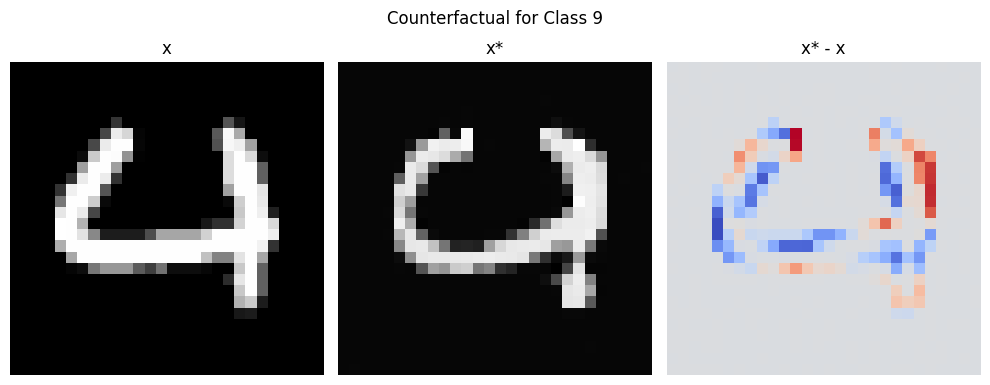

In [6]:
sample = train_data[60][0].unsqueeze(0).to(device)
reconstructed = counterfactual(flow, sample, 9, 0.99)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))


ax1.imshow(sample.squeeze().detach().cpu().numpy(), cmap='gray')
ax1.axis('off')
ax1.set_title('x')

rec_img = reconstructed[0].squeeze().detach().cpu().numpy()
ax2.imshow(reconstructed[0].squeeze().detach().cpu().numpy(), cmap='gray')
ax2.axis('off')
ax2.set_title('x*')
# for both immages, sum the absolute values of each color channel
ax3.imshow((reconstructed[0] - sample).detach().cpu().numpy()[0][0], cmap='coolwarm')
ax3.axis('off')
ax3.set_title('x* - x')

fig.suptitle('Counterfactual for Class 9')
fig.tight_layout()
plt.show()

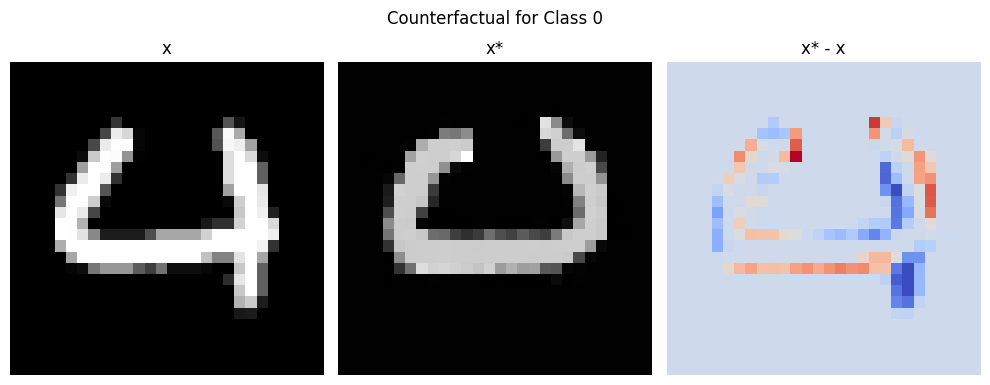

In [7]:
sample = train_data[60][0].unsqueeze(0).to(device)
reconstructed = counterfactual(flow, sample, 0, 0.99)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))


ax1.imshow(sample.squeeze().detach().cpu().numpy(), cmap='gray')
ax1.axis('off')
ax1.set_title('x')

rec_img = reconstructed[0].squeeze().detach().cpu().numpy()
ax2.imshow(reconstructed[0].squeeze().detach().cpu().numpy(), cmap='gray')
ax2.axis('off')
ax2.set_title('x*')
# for both immages, sum the absolute values of each color channel
ax3.imshow((reconstructed[0]-sample).detach().cpu().numpy()[0][0], cmap='coolwarm')
ax3.axis('off')
ax3.set_title('x* - x')

fig.suptitle('Counterfactual for Class 0')
fig.tight_layout()
plt.show()